In [1]:
%matplotlib inline
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from models.utils import loader

# Initialize CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


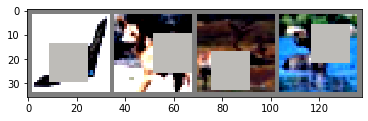

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(loader.trainloader_for_plot_alb)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
from models.resnet import ResNet18

In [5]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Device: {device}")
net = ResNet18().to(device)
summary(net, input_size=(3, 32, 32))

Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14      

In [6]:
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-7, momentum=0.9)

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()


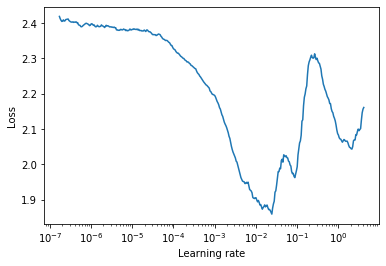

Best LR: 0.024506370946974474


In [7]:
from models.utils import lr_finder

lr_finder = lr_finder.LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(loader.trainloader_alb, end_lr=5, num_iter=400, step_mode="exp")

lr_finder.plot()

best_loss = lr_finder.best_loss
best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(best_loss)]

print(f"Best LR: {best_lr}")

lr_finder.reset()

In [8]:
from models.utils import train
from models.utils import test

In [9]:
# Optimizer with best LR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-4, factor=0.1, patience=2, verbose=True)

In [10]:
epochs = 50
last_epoch = False

train_losses = []
train_acc = []
test_acc = []
test_losses = []

for epoch in range(epochs):
    train.train(net, device, loader.trainloader_alb, optimizer, criterion, epoch, train_acc , train_losses)
    if epoch == epochs - 1:
        last_epoch = True
    test.test(net, device, loader.testloader, criterion, last_epoch, test_acc, test_losses)
    scheduler.step(test_losses[-1])

Epoch= 0 Loss=1.1405818462371826 Batch_id=390 Accuracy=42.08: 100%|██████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0100, Accuracy: 5651/10000 (56.51%)



Epoch= 1 Loss=0.9938163757324219 Batch_id=390 Accuracy=58.06: 100%|██████████████████| 391/391 [01:52<00:00,  3.47it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0072, Accuracy: 6797/10000 (67.97%)



Epoch= 2 Loss=1.1522136926651 Batch_id=390 Accuracy=65.48: 100%|█████████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 7159/10000 (71.59%)



Epoch= 3 Loss=0.7140182256698608 Batch_id=390 Accuracy=69.96: 100%|██████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 7380/10000 (73.80%)



Epoch= 4 Loss=0.7351621985435486 Batch_id=390 Accuracy=73.32: 100%|██████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 7905/10000 (79.05%)



Epoch= 5 Loss=0.6261884570121765 Batch_id=390 Accuracy=75.80: 100%|██████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0052, Accuracy: 7775/10000 (77.75%)



Epoch= 6 Loss=0.6035202145576477 Batch_id=390 Accuracy=77.49: 100%|██████████████████| 391/391 [01:52<00:00,  3.46it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0054, Accuracy: 7861/10000 (78.61%)



Epoch= 7 Loss=0.654679000377655 Batch_id=390 Accuracy=79.16: 100%|███████████████████| 391/391 [01:53<00:00,  3.43it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0038, Accuracy: 8336/10000 (83.36%)



Epoch= 8 Loss=0.35618433356285095 Batch_id=390 Accuracy=80.46: 100%|█████████████████| 391/391 [01:52<00:00,  3.46it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 8190/10000 (81.90%)



Epoch= 9 Loss=0.37582874298095703 Batch_id=390 Accuracy=81.68: 100%|█████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0036, Accuracy: 8504/10000 (85.04%)



Epoch= 10 Loss=0.41546574234962463 Batch_id=390 Accuracy=82.75: 100%|████████████████| 391/391 [01:52<00:00,  3.47it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8587/10000 (85.87%)



Epoch= 11 Loss=0.553385853767395 Batch_id=390 Accuracy=83.92: 100%|██████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 8099/10000 (80.99%)



Epoch= 12 Loss=0.3980424404144287 Batch_id=390 Accuracy=84.71: 100%|█████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0041, Accuracy: 8356/10000 (83.56%)



Epoch= 13 Loss=0.39091023802757263 Batch_id=390 Accuracy=85.53: 100%|████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0034, Accuracy: 8558/10000 (85.58%)

Epoch    14: reducing learning rate of group 0 to 2.4506e-03.


Epoch= 14 Loss=0.23549464344978333 Batch_id=390 Accuracy=89.85: 100%|████████████████| 391/391 [01:52<00:00,  3.48it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8849/10000 (88.49%)



Epoch= 15 Loss=0.26920804381370544 Batch_id=390 Accuracy=90.64: 100%|████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0027, Accuracy: 8867/10000 (88.67%)



Epoch= 16 Loss=0.2512708306312561 Batch_id=390 Accuracy=91.17: 100%|█████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0027, Accuracy: 8893/10000 (88.93%)



Epoch= 17 Loss=0.1661897748708725 Batch_id=390 Accuracy=91.82: 100%|█████████████████| 391/391 [01:52<00:00,  3.47it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8920/10000 (89.20%)



Epoch= 18 Loss=0.145137220621109 Batch_id=390 Accuracy=91.98: 100%|██████████████████| 391/391 [01:51<00:00,  3.50it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0029, Accuracy: 8914/10000 (89.14%)



Epoch= 19 Loss=0.23473353683948517 Batch_id=390 Accuracy=92.52: 100%|████████████████| 391/391 [01:52<00:00,  3.46it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8917/10000 (89.17%)

Epoch    20: reducing learning rate of group 0 to 2.4506e-04.


Epoch= 20 Loss=0.20901799201965332 Batch_id=390 Accuracy=93.23: 100%|████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0027, Accuracy: 8928/10000 (89.28%)



Epoch= 21 Loss=0.2607041895389557 Batch_id=390 Accuracy=93.35: 100%|█████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8935/10000 (89.35%)



Epoch= 22 Loss=0.0729900449514389 Batch_id=390 Accuracy=93.31: 100%|█████████████████| 391/391 [01:53<00:00,  3.46it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8932/10000 (89.32%)

Epoch    23: reducing learning rate of group 0 to 1.0000e-04.


Epoch= 23 Loss=0.1902758926153183 Batch_id=390 Accuracy=93.52: 100%|█████████████████| 391/391 [01:52<00:00,  3.48it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8933/10000 (89.33%)



Epoch= 24 Loss=0.21016068756580353 Batch_id=390 Accuracy=93.44: 100%|████████████████| 391/391 [01:55<00:00,  3.39it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0029, Accuracy: 8920/10000 (89.20%)



Epoch= 25 Loss=0.0971163660287857 Batch_id=390 Accuracy=93.54: 100%|█████████████████| 391/391 [01:57<00:00,  3.33it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8940/10000 (89.40%)



Epoch= 26 Loss=0.06107982248067856 Batch_id=390 Accuracy=93.40: 100%|████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0027, Accuracy: 8929/10000 (89.29%)



Epoch= 27 Loss=0.2529658079147339 Batch_id=390 Accuracy=93.39: 100%|█████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8933/10000 (89.33%)



Epoch= 28 Loss=0.12319247424602509 Batch_id=390 Accuracy=93.62: 100%|████████████████| 391/391 [01:54<00:00,  3.42it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8940/10000 (89.40%)



Epoch= 29 Loss=0.20989683270454407 Batch_id=390 Accuracy=93.46: 100%|████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8932/10000 (89.32%)



Epoch= 30 Loss=0.15605178475379944 Batch_id=390 Accuracy=93.37: 100%|████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8930/10000 (89.30%)



Epoch= 31 Loss=0.10221028327941895 Batch_id=390 Accuracy=93.54: 100%|████████████████| 391/391 [01:52<00:00,  3.46it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8936/10000 (89.36%)



Epoch= 32 Loss=0.3246871829032898 Batch_id=390 Accuracy=93.58: 100%|█████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8941/10000 (89.41%)



Epoch= 33 Loss=0.18578125536441803 Batch_id=390 Accuracy=93.60: 100%|████████████████| 391/391 [01:54<00:00,  3.41it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8940/10000 (89.40%)



Epoch= 34 Loss=0.18263757228851318 Batch_id=390 Accuracy=93.49: 100%|████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8945/10000 (89.45%)



Epoch= 35 Loss=0.14859190583229065 Batch_id=390 Accuracy=93.64: 100%|████████████████| 391/391 [01:54<00:00,  3.43it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8933/10000 (89.33%)



Epoch= 36 Loss=0.2036881446838379 Batch_id=390 Accuracy=93.60: 100%|█████████████████| 391/391 [01:54<00:00,  3.42it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8939/10000 (89.39%)



Epoch= 37 Loss=0.15256838500499725 Batch_id=390 Accuracy=93.69: 100%|████████████████| 391/391 [01:52<00:00,  3.46it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8939/10000 (89.39%)



Epoch= 38 Loss=0.17536285519599915 Batch_id=390 Accuracy=93.76: 100%|████████████████| 391/391 [01:52<00:00,  3.47it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0027, Accuracy: 8941/10000 (89.41%)



Epoch= 39 Loss=0.1719137728214264 Batch_id=390 Accuracy=93.68: 100%|█████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8941/10000 (89.41%)



Epoch= 40 Loss=0.11151695251464844 Batch_id=390 Accuracy=93.67: 100%|████████████████| 391/391 [01:53<00:00,  3.43it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8934/10000 (89.34%)



Epoch= 41 Loss=0.17041555047035217 Batch_id=390 Accuracy=93.84: 100%|████████████████| 391/391 [01:53<00:00,  3.46it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8933/10000 (89.33%)



Epoch= 42 Loss=0.10528914630413055 Batch_id=390 Accuracy=93.79: 100%|████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8943/10000 (89.43%)



Epoch= 43 Loss=0.34388071298599243 Batch_id=390 Accuracy=94.01: 100%|████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8936/10000 (89.36%)



Epoch= 44 Loss=0.20966430008411407 Batch_id=390 Accuracy=93.81: 100%|████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8940/10000 (89.40%)



Epoch= 45 Loss=0.1491837203502655 Batch_id=390 Accuracy=93.79: 100%|█████████████████| 391/391 [01:52<00:00,  3.48it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8926/10000 (89.26%)



Epoch= 46 Loss=0.2426108568906784 Batch_id=390 Accuracy=93.78: 100%|█████████████████| 391/391 [01:53<00:00,  3.45it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0029, Accuracy: 8930/10000 (89.30%)



Epoch= 47 Loss=0.203705832362175 Batch_id=390 Accuracy=94.06: 100%|██████████████████| 391/391 [01:53<00:00,  3.44it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8934/10000 (89.34%)



Epoch= 48 Loss=0.17061229050159454 Batch_id=390 Accuracy=93.71: 100%|████████████████| 391/391 [01:53<00:00,  3.46it/s]
  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 8929/10000 (89.29%)



Epoch= 49 Loss=0.1820249855518341 Batch_id=390 Accuracy=93.91: 100%|█████████████████| 391/391 [01:53<00:00,  3.44it/s]



Validation set: Average loss: 0.0028, Accuracy: 8941/10000 (89.41%)



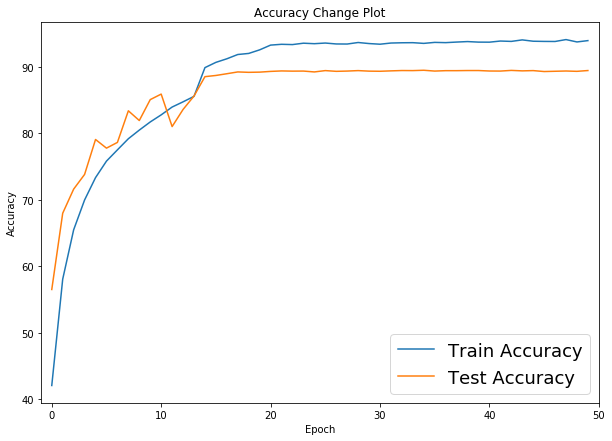

In [11]:
acc_fig, axs = plt.subplots(1,1,figsize=(10,7))
axs.set_xlim([-1, 50])
axs.plot(train_acc, label='Train Accuracy')
axs.plot(test_acc, label='Test Accuracy')
axs.set_title("Accuracy Change Plot")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
axs.legend(loc='lower right', prop={'size': 18})

acc_fig.savefig('accuracy_change_plot.jpg')

In [12]:
test.test_class_performance(net, device, loader.testloader, classes)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.76it/s]

Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 73 %
Accuracy of   cat : 77 %
Accuracy of  deer : 89 %
Accuracy of   dog : 89 %
Accuracy of  frog : 93 %
Accuracy of horse : 97 %
Accuracy of  ship : 97 %
Accuracy of truck : 85 %
